# 895 Practical Machine Learning and Applications - Project 1
# Joseph Martínez Salcedo - 01236703

In [1]:
import os

import torch
import torch.optim as optim

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [3]:
from pathlib import Path

def count_files_in_folder(folder_path):
    folder = Path(folder_path)
    return len([f for f in folder.iterdir() if f.is_file()])

folder_path = './kaggle/train_images/'
file_count = count_files_in_folder(folder_path)
print("Number of files in the folder:", file_count)

Number of files in the folder: 18632


In [4]:
# Import the images and labels from kaggle

train_labels_path = './kaggle/train.csv'
train_dir ='./kaggle/train_images'
test_dir='./kaggle/test_images'

train_labels=pd.read_csv(train_labels_path)


print(f'Number of images = {len(train_labels)}')

train_labels.head(4)

Number of images = 18632


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab


In [5]:
class_list = list(train_labels["labels"].value_counts().index)
class_list

['scab',
 'healthy',
 'frog_eye_leaf_spot',
 'rust',
 'complex',
 'powdery_mildew',
 'scab frog_eye_leaf_spot',
 'scab frog_eye_leaf_spot complex',
 'frog_eye_leaf_spot complex',
 'rust frog_eye_leaf_spot',
 'rust complex',
 'powdery_mildew complex']

In [6]:
# Plotting one image

i=0

name_img = train_labels.iloc[i, 0]
label_name_img=train_labels.iloc[i,1]

img = Image.open(os.path.join(train_dir, name_img[:-4]+".jpg"))
plt.imshow(img)
plt.title(label_name_img)

Text(0.5, 1.0, 'healthy')

In [13]:
# Resizing the images to 64x64

from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor,InterpolationMode, ColorJitter

# Define data transformations
resizing = Resize([64, 64],interpolation=InterpolationMode.BICUBIC)   #1. Resize the image to 64x64 pixels
increase_saturation = ColorJitter(saturation=4)                         #2. Increase the saturation of the image


transform = Compose([resizing,increase_saturation,ToTensor()])

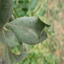

In [14]:
Image.fromarray(transform(img).mul(255).permute(1, 2, 0).byte().numpy())

In [15]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class CustomTextLabelDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.csv_path = csv_path
        self.images_root = image_dir
        self.transform = transform
        self.data = self.load_data()

    def load_data(self):
        # Load data from the CSV file
        df = pd.read_csv(self.csv_path)

        # Combine filename and label information
        data = [{'filename': row['image'], 'label': row['labels']} for _, row in df.iterrows()]

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        entry = self.data[index]
        image_path = os.path.join(self.images_root, entry['filename'])
        text_label = entry['label']

        # Load image
        image = Image.open(image_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, text_label

In [16]:
# Specify the path to CSV file and images directory

## dataset:
full_dataset = CustomTextLabelDataset(csv_path=train_labels_path, image_dir=train_dir, transform=transform)
#access label
full_dataset[0][1]

'healthy'

In [39]:
import torch
import torch.nn as nn

class CNN_model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_model, self).__init__()

        #### 1st Convolutional Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # ReLU activation
        self.relu1 = nn.ReLU()
        # Max-pooling layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #### 2nd Convolutional Layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # ReLU activation
        self.relu2 = nn.ReLU()
        # Max-pooling layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #### 3rd Convolutional Layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # ReLU activation
        self.relu3 = nn.ReLU()
        # Max-pooling layer
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        ### Fully Connected Layer
        self.fc = nn.Linear(64 * 32 * 2, num_classes)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


num_classes = 12  # we have 12 classes here
model = CNN_model(num_classes)

model

CNN_model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=12, bias=True)
)

In [40]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        #focul loss 
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha*(1 - pt) ** self.gamma * ce_loss
        
        #if self.alpha is not None:
            #alpha_factor = self.alpha[targets]
            #focal_loss = focal_loss * alpha_factor


        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        elif self.reduction == 'none':
            return focal_loss
        else:
            raise ValueError("Invalid reduction option. Use 'mean', 'sum', or 'none'.")


Since the labels are given in text format I made a mapping to turn text into numerics and vice-versa
*********************

In [41]:
# Create a mapping between text labels and numerical indices
unique_text_labels = class_list
label_to_index = {label: index for index, label in enumerate(unique_text_labels)}
index_to_label = {index: label for label, index in label_to_index.items()}


TRAINING ON train_images:
*************************************************************************************************
Used Adam optimizer with learning rate 0.01.


the model is saved locally at 'cnn_model.pth'

In [42]:
from torch.utils.data import DataLoader, random_split
#from torch.optim.lr_scheduler import StepLR

# Define the focal loss function and optimizer:
criterion = FocalLoss(gamma=2, alpha=1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
#step_scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Wrap model and optimizer with XLA
#model, optimizer = xm.initialize_model(model, optimizer, opt_level="O2")


# Split the dataset into training and validation sets: 80:20
train_size = int(0.08 * len(full_dataset))
val_size = int(0.02 * len(full_dataset))
not_used_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, not_used = random_split(full_dataset, [train_size, val_size, not_used_size])
print(len(train_dataset))

# Create data loaders for training and validation
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))


# Use GPU for model
model.to(device)


epochs = 4

for epoch in range(epochs):
    
    ## Training loop:
    
    model.train()  # Set the model to training mode
    
    #run=0
    for inputs, text_labels in train_loader:
        inputs, text_labels = inputs.to(device), text_labels
        
        #print('input',inputs)
        #print('text_labels',text_labels)
        #print(inputs.shape)
        
        # Convert text labels to numerical indices using the mapping
        numerical_labels = [label_to_index[label] for label in text_labels]
        #print((numerical_labels))
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        #print(outputs.shape)
        #print(torch.tensor(numerical_labels).shape)
        
        loss=criterion(outputs, torch.tensor(numerical_labels).to(device))  # Focal Loss
        
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        
        #print(f'{run}run done')
        #run=run+1
        
    #print(f'train loss for {epoch+1} epoch = {loss:0.3f} ')
    
    ###Validation loop:
    
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, text_labels in val_loader:
            inputs, text_labels = inputs.to(device), text_labels
            
            
            numerical_labels = [label_to_index[label] for label in text_labels]
            numerical_labels=torch.tensor(numerical_labels).to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += len(numerical_labels)
            correct += (predicted == numerical_labels).sum().item()
            
            #step_scheduler.step()
    
    accuracy = correct / total
    print(f'Epoch {epoch+1}/{epochs}, Train Set Loss: {loss.item():.4f}, Validation Set Accuracy: {accuracy:.4f}')




1490
1
Epoch 1/4, Train Set Loss: 2.0683, Validation Set Accuracy: 0.2823
Epoch 2/4, Train Set Loss: 1.8902, Validation Set Accuracy: 0.2715
Epoch 3/4, Train Set Loss: 1.6784, Validation Set Accuracy: 0.2688
Epoch 4/4, Train Set Loss: 1.4862, Validation Set Accuracy: 0.2581


In [43]:
## Save the trained model:
torch.save(model.state_dict(), './kaggle/cnn_model.pth')
